In [88]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import qutip
import theano
import theano.tensor as T
from collections import OrderedDict
import itertools
import os
import sys

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

import qubit_network as qn
from utils import *

pairs = list(itertools.combinations(range(4), 2))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test with interactions from [*Banchi et al.*](https://arxiv.org/abs/1509.04298).
The Fredkin gate is indeed reproduced with good fidelity, and regardless of the initial ancilla state.

In [3]:
net_paper = qn.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['zz', 'xx', 'yy', 'z', 'x']),
    ancillae_state=qutip.basis(2, 0),
    target_gate=qutip.fredkin()
)
net_paper.J.set_value(np.zeros_like(net_paper.J.get_value()))

Jvalues = net_paper.J.get_value()

J01xx = 13.6
J02xx = J01xx
J12xx = -4.712
J12yy = J12zz = J12xx
J13xx = 8.4
J23xx = J13xx
J01zz = 11.15
J02zz = J01zz
h3x = 1.025
h0z = np.pi

Jvalues[net_paper.tuple_to_J_index(((0, 1), 'xx'))] = J01xx / 4
Jvalues[net_paper.tuple_to_J_index(((0, 2), 'xx'))] = J02xx / 4
Jvalues[net_paper.tuple_to_J_index(((1, 2), 'xx'))] = J12xx / 4
Jvalues[net_paper.tuple_to_J_index(((1, 2), 'yy'))] = J12yy / 4
Jvalues[net_paper.tuple_to_J_index(((1, 2), 'zz'))] = J12zz / 4
Jvalues[net_paper.tuple_to_J_index(((1, 3), 'xx'))] = J13xx / 4
Jvalues[net_paper.tuple_to_J_index(((2, 3), 'xx'))] = J23xx / 4
Jvalues[net_paper.tuple_to_J_index(((0, 1), 'zz'))] = J01zz / 4
Jvalues[net_paper.tuple_to_J_index(((0, 2), 'zz'))] = J02zz / 4
Jvalues[net_paper.tuple_to_J_index((0, 'z'))] = h0z / 2
Jvalues[net_paper.tuple_to_J_index((3, 'x'))] = h3x / 2

net_paper.J.set_value(Jvalues)

print('Fidelity: {}'.format(net_paper.test_fidelity(n_samples=1000)))

gate = qutip.Qobj(net_paper.get_current_gate(), dims=[[2, 2, 2, 2]] * 2)
gate = chop(gate).ptrace([0, 1, 2])
gate = gate * np.exp(-1j * np.angle(gate[0, 0]))
gate = gate / gate[0, 0]
chop(gate, 0.01)

Fidelity: 0.9999985454189124


Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.99999938  0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.99999938  0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.99999776  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.99999641  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.99999911  0.        ]
 [ 0.          0.          0.          0.          0.          0.99999911
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.99999962]]

Using the same identical topology as per the paper, and the same set of initial interactions, the perfect fidelity is reproduced without problems (also, the net is saved into `data/nets/fredkin_Banchietal.pickle`):

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


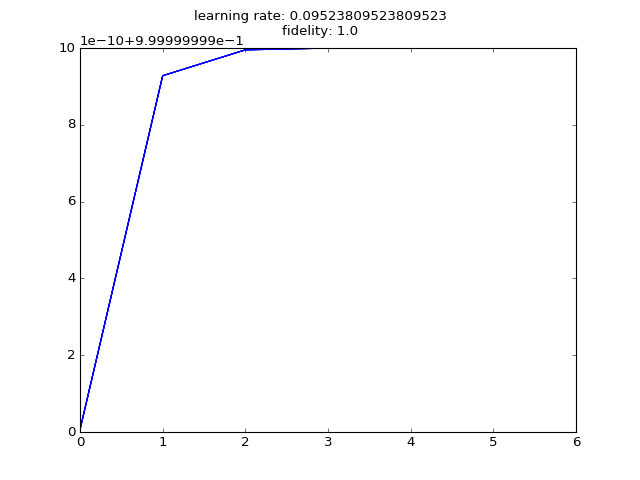

Finished training
Final fidelity: 0.999999999999999


In [4]:
# set up the same topology of Banchi et al.
net_topology = OrderedDict()
net_topology[((0, 1), 'xx')] = '1'
net_topology[((0, 2), 'xx')] = '1'
net_topology[((1, 2), 'xx')] = '2'
net_topology[((1, 2), 'yy')] = '2'
net_topology[((1, 2), 'zz')] = '2'
net_topology[((1, 3), 'xx')] = '3'
net_topology[((2, 3), 'xx')] = '3'
net_topology[((0, 1), 'zz')] = '4'
net_topology[((0, 2), 'zz')] = '4'
net_topology[(3, 'x')] = '5'
net_topology[(0, 'z')] = '6'

# define the network
net = qn.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    ancillae_state=qutip.basis(2, 0),
    net_topology=net_topology,
    target_gate=qutip.fredkin()
)
# insert the values given in the paper
net.J.set_value(np.array([13.6 / 4, -4.712 / 4, 8.4 / 4, 11.15 / 4, 1.025 / 2, 3.141 / 2]))

# train the network
qn.sgd_optimization(
    net=net,
    learning_rate=.1,
    n_epochs=10,
    batch_size=2,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Load the above net from file, and analyze the corresponding matrix.

Tracing over the ancilla, multiplying the whole matrix with a global phase, and chopping away the small matrix elements, we get a perfect Fredkin over the system qubits.

In [62]:
gate = net.get_current_gate()
psi_in = qutip.rand_ket(2 ** 3)
psi_in.dims = [[2, 2, 2], [1, 1, 1]]
Psi_in = qutip.tensor(psi_in, qutip.basis(2, 0))

Psi_out = gate * Psi_in
dm_out = Psi_out.ptrace([0, 1, 2])

# psi_in.dag() * qutip.fredkin().dag() * dm_out * qutip.fredkin() * psi_in
(dm_out * dm_out).tr()

0.9999999992792538

In [25]:
net = qn.load_network_from_file('../data/nets/fredkin_Banchietal.pickle')
qn.trace_ancillae_and_normalize(net)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.74304268  0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          1.74304268  0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          1.74304268  0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          1.74304267  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          1.74304268  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.74304268  0.        ]
 [ 0.          0.          0.          0.          0.          1.74304268
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.74304267]]

In [91]:
net = qn.load_network_from_file('../data/nets/fredkin_Banchietal.pickle')
gate = net.get_current_gate().ptrace([3]) / 6
chop(qn.normalize_phase(gate)).tr()

(1.743042674821862+0j)